In [25]:
# pip install sktime

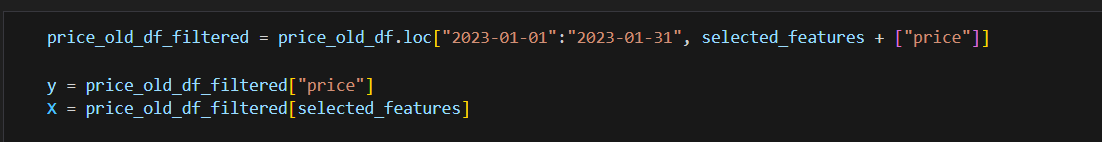

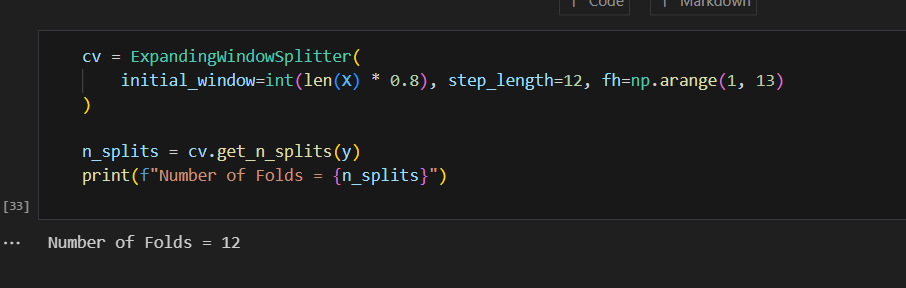

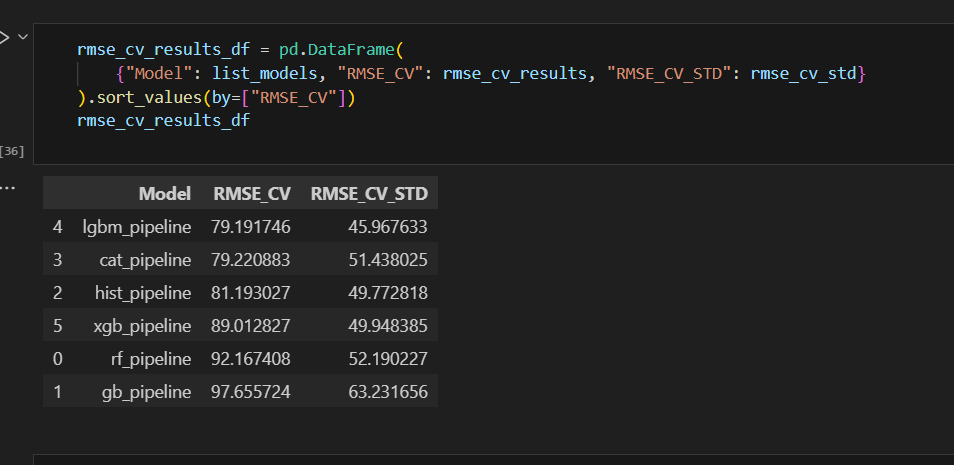

In [26]:
import pandas as pd
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import numpy as np
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Detrender
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sklearn.metrics import mean_squared_error
from sktime.forecasting.compose import make_reduction
from sklearn.exceptions import ConvergenceWarning
import requests
from sklearn.ensemble import (
    HistGradientBoostingRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.linear_model import ElasticNetCV
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    ExpandingWindowSplitter,
)
from sktime.forecasting.compose import MultiplexForecaster
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.ets import AutoETS
from sktime.transformations.series.boxcox import LogTransformer


import warnings

In [27]:
from sklearn.preprocessing import StandardScaler
from sktime.forecasting.compose import ForecastingPipeline
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.forecasting.arima import AutoARIMA


def initialize_arima_forecaster():
    pipe = TransformedTargetForecaster(
                    [
                        (
                            "deseasonalizer_daily",
                            Deseasonalizer(sp=24, model="additive"),
                        ),
                        ("residual_forecaster", AutoARIMA(suppress_warnings=True)),
                    ]
                ),

    return pipe


def initialize_elasticnet_forecaster():
    pipe = TransformedTargetForecaster(
                    [
                        (
                            "forecast",
                            make_reduction(
                                ElasticNetCV(n_jobs=-1),
                                window_length=24,
                                strategy="direct",
                            ),
                        ),
                    ]
                )

    return pipe


def initialize_rf_forecaster():
    pipe = TransformedTargetForecaster(
                    [
                        (
                            "forecast",
                            make_reduction(
                                RandomForestRegressor(n_estimators=100, n_jobs=-1),
                                window_length=24,
                                strategy="direct",
                            ),
                        ),
                    ]
                )

    return pipe


def initialize_gb_forecaster():
    pipe = TransformedTargetForecaster(
                    [
                        (
                            "forecast",
                            make_reduction(
                                GradientBoostingRegressor(n_estimators=200),
                                window_length=24,
                                strategy="direct",
                            ),
                        ),
                    ]
                )
           
    return pipe


def initialize_hist_forecaster():
    deseasonalizer_daily = Deseasonalizer(sp=24, model="additive")
    pipe = TransformedTargetForecaster(
                    [
                        (
                            "forecast",
                            make_reduction(
                                HistGradientBoostingRegressor(),
                                window_length=24,
                                strategy="direct",
                            ),
                        ),
                    ]
                )
            
    return pipe


from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


def initialize_cat_forecaster():
    pipe = TransformedTargetForecaster(
                    [
                        (
                            "forecast",
                            make_reduction(
                                CatBoostRegressor(verbose=0, n_estimators=100),
                                window_length=24,
                                strategy="direct",
                            ),
                        ),
                    ]
                )

    return pipe


def initialize_lgbm_forecaster():
    pipe = TransformedTargetForecaster(
                    [
                        (
                            "forecast",
                            make_reduction(
                                LGBMRegressor(),
                                window_length=24,
                                strategy="direct",
                            ),
                        ),
                    ]
                )

    return pipe


def initialize_xgb_forecaster():
    pipe = TransformedTargetForecaster(
                    [
                        (
                            "forecast",
                            make_reduction(
                                XGBRegressor(objective="reg:squarederror"),
                                window_length=24,
                                strategy="direct",
                            ),
                        ),
                    ]
                )

    return pipe

In [28]:
arima_pipeline = initialize_arima_forecaster()
elasticnet_pipeline = initialize_elasticnet_forecaster()
rf_pipeline = initialize_rf_forecaster()
gb_pipeline = initialize_gb_forecaster()
hist_pipeline = initialize_hist_forecaster()
cat_pipeline = initialize_cat_forecaster()
lgbm_pipeline = initialize_lgbm_forecaster()
xgb_pipeline = initialize_xgb_forecaster()


forecasting_models = {
    "arima_pipeline": arima_pipeline,
    "elasticnet_pipeline": elasticnet_pipeline,
    "rf_pipeline": rf_pipeline,
    "gb_pipeline": gb_pipeline,
    "hist_pipeline": hist_pipeline,
    "arima_pipeline": arima_pipeline,
    "cat_pipeline": cat_pipeline,
    "lgbm_pipeline": lgbm_pipeline,
    "xgb_pipeline": xgb_pipeline,
}

c:\Users\rkris\miniconda3\envs\slalomenv\Lib\site-packages\sktime\forecasting\compose\_reduce.py:1480: UserWarning: The `scitype` of the given `estimator` cannot be inferred. Assuming "tabular-regressor" = scikit-learn regressor interface. If this warning is followed by an unexpected exception, please consider report as a bug on the sktime issue tracker.
  warn(


In [29]:
selected_features = [
    "ail",
    "gas_price",
    "gas_tng",
    "coal_tng",
    "wind_tng",
    "gas_avail",
    "wind_avail",
    "gas_reserve_margin",
    "coal_reserve_margin",
    "wind_reserve_margin",
    "other_reserve_margin",
    "gas_supply_mix",
    "coal_supply_mix",
    "wind_supply_mix",
    "other_supply_mix",
    "total_reserve_margin",
    "demand_supply_ratio",
    "fossil_fuel_ratio",
    "rolling_mean",
    "rolling_std",
    "rolling_min",
    "rolling_max",
    "rolling_median",
    "exp_moving_avg",
]

In [30]:
price_old_df = pd.read_csv(
    "https://raw.githubusercontent.com/slalom-ubc-mds/Power-Price-Prediction/main/data/processed/supply_load_price.csv",
    parse_dates=["Date (MST)"],
    index_col="Date (MST)",
)

window = 24
price_old_df = price_old_df.sort_values(by="Date (MST)")
price_old_df = price_old_df.asfreq("H")

price_old_df['rolling_mean'] = price_old_df['price'].rolling(window).mean().rolling(2).mean().shift(-window // 2)
price_old_df['rolling_std'] = price_old_df['price'].rolling(window).std().rolling(2).mean().shift(-window // 2)
price_old_df['rolling_min'] = price_old_df['price'].rolling(window).min().rolling(2).mean().shift(-window // 2)
price_old_df['rolling_max'] = price_old_df['price'].rolling(window).max().rolling(2).mean().shift(-window // 2)
price_old_df['rolling_median'] = price_old_df['price'].rolling(window).median().rolling(2).mean().shift(-window // 2)
price_old_df['exp_moving_avg'] = price_old_df['price'].ewm(span=24).mean()

In [31]:
price_old_df_filtered = price_old_df.loc["2023-01-01":"2023-01-31", selected_features + ["price"]]

y = price_old_df_filtered["price"]
X = price_old_df_filtered[selected_features]

# scale ratios to percentages
X["gas_supply_mix"] = X["gas_supply_mix"] * 100
X["coal_supply_mix"] = X["coal_supply_mix"] * 100
X["wind_supply_mix"] = X["wind_supply_mix"] * 100
X["other_supply_mix"] = X["other_supply_mix"] * 100
X['gas_reserve_margin'] = X['gas_reserve_margin'] * 100
X['coal_reserve_margin'] = X['coal_reserve_margin'] * 100
X['wind_reserve_margin'] = X['wind_reserve_margin'] * 100
X['other_reserve_margin'] = X['other_reserve_margin'] * 100
X['total_reserve_margin'] = X['total_reserve_margin'] * 100
X['demand_supply_ratio'] = X['demand_supply_ratio'] * 100
X['fossil_fuel_ratio'] = X['fossil_fuel_ratio'] * 100

C:\Users\rkris\AppData\Local\Temp\ipykernel_34012\3940189037.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["gas_supply_mix"] = X["gas_supply_mix"] * 100
C:\Users\rkris\AppData\Local\Temp\ipykernel_34012\3940189037.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["coal_supply_mix"] = X["coal_supply_mix"] * 100
C:\Users\rkris\AppData\Local\Temp\ipykernel_34012\3940189037.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [32]:
# standardize features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

In [33]:
cv = ExpandingWindowSplitter(
    initial_window=int(len(X) * 0.8), step_length=12, fh=np.arange(1, 13)
)

n_splits = cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

Number of Folds = 12


In [34]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import MeanSquaredScaledError, MeanSquaredError

list_models = ["rf_pipeline", "gb_pipeline", "hist_pipeline", "cat_pipeline", "lgbm_pipeline", "xgb_pipeline"]

rmse_cv_results = []
rmse_cv_std = []
for i in list_models:
    print(i)
    results = evaluate(
        forecaster=forecasting_models[i],
        y=y,
        X=X,
        cv=cv,
        strategy="refit",
        return_data=True,
        scoring=MeanSquaredError(square_root=True),
        backend="loky",
        error_score='raise'
    )
    
    rmse = results["test_MeanSquaredError"].mean()
    rmse_std = results["test_MeanSquaredError"].std()
    rmse_cv_results.append(rmse)
    rmse_cv_std.append(rmse_std)

rf_pipeline
gb_pipeline
hist_pipeline
cat_pipeline
lgbm_pipeline
xgb_pipeline


In [36]:
rmse_cv_results_df = pd.DataFrame(
    {"Model": list_models, "RMSE_CV": rmse_cv_results, "RMSE_CV_STD": rmse_cv_std}
).sort_values(by=["RMSE_CV"])
rmse_cv_results_df

,Model,RMSE_CV,RMSE_CV_STD
4,lgbm_pipeline,79.191746,45.967633
3,cat_pipeline,79.220883,51.438025
2,hist_pipeline,81.193027,49.772818
5,xgb_pipeline,89.012827,49.948385
0,rf_pipeline,92.167408,52.190227
1,gb_pipeline,97.655724,63.231656


In [38]:
forecasting_models[i].is_fitted

False

In [35]:
price_old_df = pd.read_csv(
    "https://raw.githubusercontent.com/slalom-ubc-mds/Power-Price-Prediction/main/data/processed/supply_load_price.csv",
    parse_dates=["Date (MST)"],
    index_col="Date (MST)",
)

In [36]:
train = price_old_df.loc["2023-01-01":"2023-01-31", selected_features+["price"]]
test = price_old_df.loc["2023-02-01":"2023-02-02", selected_features+["price"]]
train = train.sort_values(by="Date (MST)")
train = train.asfreq("H")
test = test.sort_values(by="Date (MST)")
test = test.asfreq("H")
X_train = train[selected_features]
y_train = train["price"]
X_test = test[selected_features]
y_test = test["price"]

KeyError: "['rolling_mean', 'rolling_std', 'rolling_min', 'rolling_max', 'rolling_median', 'exp_moving_avg'] not in index"

In [ ]:
# fit and predict for all models
fh = np.arange(1, 13)
for i in list_models:
    print(i)
    forecasting_models[i].fit(y_train, X_train, fh=fh)
    y_pred = forecasting_models[i].predict(fh, X_train.tail(1))
    # get rmse between y_pred and y_test[:12]
    rmse = mean_squared_error(y_test[:12], y_pred, squared=False)
    print(rmse)